In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[5]: [FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1679589332000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1677683107000),
 FileInfo(path='dbfs:/FileStore/tables/TS021_2021_2.csv', name='TS021_2021_2.csv', size=497239, modificationTime=1679508416000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1675271048000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.csv', name='clinicaltrial_2019.csv', size=42400056, modificationTime=1681666373000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.zip', name='clinicaltrial_2019.zip', size=9707871, modificationTime=1681659047000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', 

In [0]:
#converting the csv file to dataframes

clinic_df = spark.read.option("header", True).option("escape",'\"').option("sep", "|").csv("/FileStore/tables/clinicaltrial_2021.csv")
pharma_df = spark.read.option("header", True).option("escape",'\"').csv("/FileStore/tables/pharma.csv")

In [0]:
#from spark.sql.functions import * as f 

import pyspark.sql.functions as f

In [0]:
# Answer to Question 1.

clinic_df.filter("Type != ' '") \
   .groupby('Type') \
   .count() \
   .toDF('Type', 'frequency') \
   .select(f.sum('frequency').alias("Total_Studies"))  \
   .show(5)

+-------------+
|Total_Studies|
+-------------+
|       387261|
+-------------+



In [0]:
# Answer to Question 2

clinic_df.filter("Type != ' '") \
   .groupby('Type') \
   .count() \
   .toDF('Type', 'frequency') \
   .orderBy('frequency', ascending=False) \
   .show(5)

+--------------------+---------+
|                Type|frequency|
+--------------------+---------+
|      Interventional|   301472|
|       Observational|    77540|
|Observational [Pa...|     8180|
|     Expanded Access|       69|
+--------------------+---------+



In [0]:
# Answer to Question 3
clinic_df.select(f.explode(f.split("Conditions", ",")).alias("Conditions")) \
            .withColumn("Conditions", f.trim("Conditions")) \
            .groupby("Conditions") \
            .count() \
            .orderBy("count", ascending=False) \
            .show(5)

+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



In [0]:
# Answer to Question 4
ph_qst4=pharma_df.filter("Parent_Company != ' '") \
   .select(f.col("Parent_Company").alias("Pham_Company")) \
   .withColumn("Pham_Company", f.trim("Pham_Company")) 

cl__qst4=clinic_df.filter("Sponsor != ' '") \
   .select(f.col("Sponsor").alias("Pham_Company")) \
   .withColumn("Pham_Company", f.trim("Pham_Company")) 

cl__qst4.join(ph_qst4,cl__qst4.Pham_Company==ph_qst4.Pham_Company, "leftanti") \
   .groupby("Pham_Company") \
   .count() \
   .orderBy("count", ascending=False) \
   .show(10)

+--------------------+-----+
|        Pham_Company|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



In [0]:
# Answer to Question 5
clinic_df.select(f.col("Completion").alias("Completion_Date")) \
   .where("Completion_Date like '%2021%'") \
   .groupby("Completion_Date") \
   .count() \
   .toDF('Completion_Date', 'Total_Studies') \
   .select(f.from_unixtime(f.unix_timestamp(f.trim(f.substring('Completion_Date', 1, 3)),'MMM'),'MM').alias("Month"),f.col("Completion_Date"),f.col("Total_Studies")) \
   .orderBy("Month") \
   .show(50)


+-----+---------------+-------------+
|Month|Completion_Date|Total_Studies|
+-----+---------------+-------------+
|   01|       Jan 2021|         2111|
|   02|       Feb 2021|         1735|
|   03|       Mar 2021|         2447|
|   04|       Apr 2021|         2029|
|   05|       May 2021|         2112|
|   06|       Jun 2021|         3102|
|   07|       Jul 2021|         2408|
|   08|       Aug 2021|         2303|
|   09|       Sep 2021|         2901|
|   10|       Oct 2021|         2514|
|   11|       Nov 2021|         1997|
|   12|       Dec 2021|         9968|
+-----+---------------+-------------+



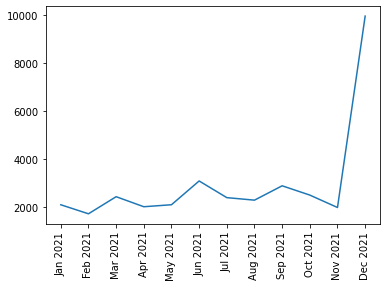

In [0]:
# Answer Question 5

Completed_Studies=clinic_df.select(f.col("Completion").alias("Completion_Date")) \
   .where("Completion_Date like '%2021%'") \
   .groupby("Completion_Date") \
   .count() \
   .toDF('Completion_Date', 'Total_Studies') \
   .select(f.from_unixtime(f.unix_timestamp(f.trim(f.substring('Completion_Date', 1, 3)),'MMM'),'MM').alias("Month"),f.col("Completion_Date"),f.col("Total_Studies")) \
   .orderBy("Month")

# getting X and Y variables for plotting
x = [row['Completion_Date'] for row in Completed_Studies.collect()]
y = [int(row['Total_Studies']) for row in Completed_Studies.collect()]
 
import matplotlib.pyplot as plt
%matplotlib inline
 
# Creating plot
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()

In [0]:
# Extra Features 

In [0]:
# the number of clinical trials sponsored by each company listed in the pharma table.

sponsor_count_df = clinic_df.join(
  pharma_df,
  clinic_df.Sponsor == pharma_df.Parent_Company,
  how="left"
).groupBy("Company").count()
sponsor_count_df.show()

+--------------------+-----+
|             Company|count|
+--------------------+-----+
|  CHIRON CORPORATION|  690|
|Actavis Mid-Atlan...|   80|
|Sanofi-Aventis U....| 1274|
|Abbott Laboratori...| 2100|
|         PLIVA, INC.|   80|
|E R SQUIBB & SONS...| 1171|
|COVIDIEN DBA MALL...|   86|
|       HOSPIRA, INC.| 2645|
|NOVARTIS CONSUMER...|  690|
|Watson Pharmaceut...|  525|
|Novartis Animal H...|  690|
|AstraZeneca Pharm...|10764|
|Novartis Vaccines...| 1380|
|AstraZeneca Pharm...| 5382|
|Forest Laboratori...|  525|
|  Mallinckrodt, Inc.|  172|
|Watson Laboratori...|  525|
|GlaxoSmithKline H...| 3378|
|      SANOFI PASTEUR| 2548|
|Teva Pharmaceutic...|   80|
+--------------------+-----+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import col

clinic_df.filter(col("Sponsor") == "Bulent Ecevit University") \
         .groupBy("Sponsor", "Conditions") \
         .count() \
         .orderBy(col("count").desc()) \
         .select(col("Sponsor"), col("Conditions"), col("count").alias("ConditionCount")) \
         .show()


+--------------------+--------------------+--------------+
|             Sponsor|          Conditions|ConditionCount|
+--------------------+--------------------+--------------+
|Bulent Ecevit Uni...|Periodontal Diseases|             4|
|Bulent Ecevit Uni...|Periodontitis,Chr...|             3|
|Bulent Ecevit Uni...|  Gingival Recession|             3|
|Bulent Ecevit Uni...|                null|             3|
|Bulent Ecevit Uni...|       Periodontitis|             2|
|Bulent Ecevit Uni...|                Pain|             2|
|Bulent Ecevit Uni...|Optic Nerve Disea...|             1|
|Bulent Ecevit Uni...|             Obesity|             1|
|Bulent Ecevit Uni...|Infections,Helico...|             1|
|Bulent Ecevit Uni...|Infections,Commun...|             1|
|Bulent Ecevit Uni...|          Hemorrhage|             1|
|Bulent Ecevit Uni...|Gingivitis,Period...|             1|
|Bulent Ecevit Uni...|    Colonic Diseases|             1|
|Bulent Ecevit Uni...|    Breast Neoplasms|             

In [0]:
## user defined function to check The number of studies in the dataset

from pyspark.sql.functions import udf, sum
from pyspark.sql.types import BooleanType
def is_not_null(val):
    return val != ""
is_not_null_udf = udf(is_not_null, BooleanType())
clinic_df.filter(is_not_null_udf(f.col("Type"))) \
           .groupby("Type") \
           .count() \
           .select(sum("count").alias("Total_Studies")) \
           .show(5)


+-------------+
|Total_Studies|
+-------------+
|       387261|
+-------------+



In [0]:
## The code uses Spark's built-in (coalesce) function to replace null values in the (Type) column with a specified default value. Making me not to use User Defined Function.

from pyspark.sql.functions import col, count, sum
total_studies_df = clinic_df.filter(col("Type").isNotNull()) \
                            .groupBy("Type") \
                            .agg(count("*").alias("Count"))
total_studies = total_studies_df.agg(sum("Count")).collect()[0][0]
total_studies_df.withColumn("Total_Studies", col("Count")/total_studies*100) \
                .orderBy(col("Total_Studies").desc()) \
                .show(5)

+--------------------+------+--------------------+
|                Type| Count|       Total_Studies|
+--------------------+------+--------------------+
|      Interventional|301472|   77.84723997510723|
|       Observational| 77540|   20.02267204805028|
|Observational [Pa...|  8180|  2.1122705358918146|
|     Expanded Access|    69|0.017817440950676677|
+--------------------+------+--------------------+



In [0]:
## In this code, the UDF is defined as a lambda function that checks if the value is not None and not an empty string. This lambda function is then passed to the udf function to create the UDF. The UDF is then used in the filter method to filter out any rows where the Type column is null or empty.

In [0]:
from pyspark.sql.functions import udf, sum
from pyspark.sql.types import BooleanType
is_not_null = udf(lambda x: x is not None and x != "", BooleanType())
clinic_df.filter(is_not_null("Type")) \
         .groupBy("Type") \
         .count() \
         .select(sum("count").alias("Total_Studies")) \
         .show(5)

+-------------+
|Total_Studies|
+-------------+
|       387261|
+-------------+

